Max caption len: 174


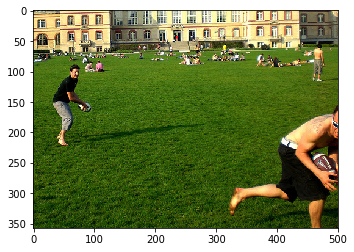

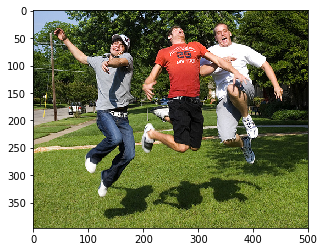

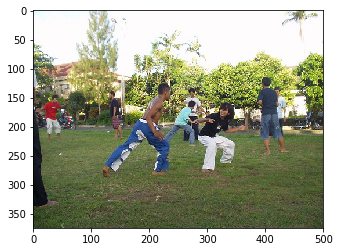

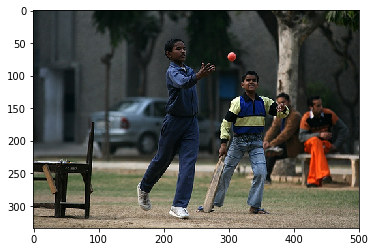

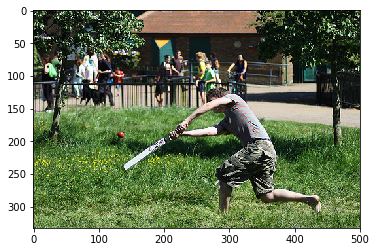

In [7]:
from model import mDAN
from process_data import *
from util import *
import torch.utils.data
import os.path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Enter the caption:
orig_caption = "People playing with a ball in the park"
#orig_caption = "People playing soccer"

# Load model
model = mDAN()
model.load_state_dict(torch.load('model_weights_53_0.298.t7'))
if torch.cuda.is_available():
    model = model.cuda()

# Get the mapping
img_caption, max_len, id_img = get_captions()
word_freq = frequency_map(img_caption)
word_idx = construct_vocab(word_freq, 5)

# Repeating the caption 5 times to fill padding
caption = orig_caption
caption += ' ' + orig_caption
caption += ' ' + orig_caption
caption += ' ' + orig_caption
caption += ' ' + orig_caption

# Get the encoded caption
one_hot, mask = encode_caption([x for x in caption.lower().split(" ")], word_idx, max_len)

# Get the visual context vectors for all the images:
class CustomDataSet(torch.utils.data.TensorDataset):
    def __init__(self):
        self.num_of_samples = len(id_img)

    def __len__(self):
        return self.num_of_samples

    def __getitem__(self, idx):
        #image = np.random.random((NO_OF_REGIONS_IN_IMAGE, VISUAL_FEATURE_DIMENSION))
        image = np.load(TRAIN_IMAGES_DIR + "{}.npy".format(id_img[idx])).reshape((NO_OF_REGIONS_IN_IMAGE, VISUAL_FEATURE_DIMENSION))
        dummy_one_hot, dummy_mask = encode_caption([x for x in ' '.split(" ")], word_idx, max_len)
        return to_tensor(dummy_one_hot).long(), to_tensor(dummy_mask), to_tensor(image)


# Get the visual context vectors for all the images:
if os.path.exists('all_visual_context_features.npy'):
    all_z_v = np.load('all_visual_context_features.npy')
else:
    all_z_v = None  # no_of_images * visual_context_features
    data_loader = torch.utils.data.DataLoader(CustomDataSet(), batch_size=BATCH_SIZE,
                                              shuffle=False)
    for (caption_, mask_, image_) in data_loader:
        _, _, z_v = model(to_variable(caption_),
                          to_variable(mask_),
                          to_variable(image_), True)
        if all_z_v is None:
            all_z_v = z_v.data.cpu()
        else:
            all_z_v = torch.cat((all_z_v, z_v.data.cpu()), 0)
    all_z_v = all_z_v.numpy()
    print(all_z_v.shape)
    np.save('all_visual_context_features.npy', all_z_v)

# Get the textual context vector for the input caption
dummy_image = np.random.random((NO_OF_REGIONS_IN_IMAGE, VISUAL_FEATURE_DIMENSION))
_, z_u, _ = model(to_variable(to_tensor(one_hot).long().unsqueeze(0)), to_variable(to_tensor(mask).unsqueeze(0)),
                  to_variable(to_tensor(dummy_image).unsqueeze(0)), True)
z_u = z_u.data.cpu().numpy()

# Compute similarity with the existing images
similarity = np.matmul(all_z_v, z_u.T)
top_5_img_idx = (-similarity.squeeze(axis=1)).argsort()[:5]

# Fetch all images
for i in top_5_img_idx:
    #print(id_img[i])
    img = mpimg.imread(IMAGES_DIR + "{}.jpg".format(id_img[i]))
    plt.figure()
    plt.imshow(img)
